# A detailed analysis of one balloon segment

This code produces Figure 1 of the paper.

Author: Brian Green (briangre@stanford.edu)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd
from dataclasses import dataclass
import warnings
from scipy.ndimage import label
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import scipy.signal
from mpl_toolkits.basemap import Basemap
warnings.simplefilter("ignore")

# For determining which times are day or night
import datetime
import pytz
import timezonefinder
import astral, astral.sun
from tqdm.notebook import tqdm

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()
    
# Replace Basemap with Cartopy:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

### Constants

In [3]:
# Physical constants
g = 9.806 # (m/s**2); acceleration due to gravity
cp = 1005 # (J/kg/K); the specific heat at constant pressure
R = 287 # (J/kg/K); the gas constant for dry air
Omega = 7.27E-5 # (s-1); the rotation rate of the Earth

# Time series properties
dt = 2.0 # (minutes) the time step of the interpolated data

# Thresholds for identifying GW packets
SN_RATIO_THRESH = 3    # the minimum ratio of the wavelet coefficients to the instrumental uncertainty
                       # for a signal to be significant
IO_PERIOD_THRESH = 1.0 # if a packet has a period more than this fraction of 2pi/f,
                       # it is deleted (the value less than one is designed to eliminate inertial oscillations)
GW_PERIOD_MIN = 10     # (minutes) the minimum period for GW packets is the maximum of this and the buoyancy period
GW_PERIOD_MAX = 1*24*60 # (minutes) the maximum period for GW packets is the minimum of this and the Coriolis period
GW_PERIOD_CUTOFF1 = 1/3 # The fraction between the buoyancy and Coriolis periods that identifies "short" period GWs
GW_PERIOD_CUTOFF2 = 2/3 # The fraction between the buoyancy and Coriolis periods that separates "medium"  from
# "long" period GWs

# Wavelet constants (same nomenclature as Torrence and Compo 1998; TC98)
omega0 = 4 # the normalized Morlet wavelet frequency
dj = 1/24 # Morlet wavelet transform parameter; see Section 3f of TC98
s0 = dt*(omega0 + np.sqrt(2 + omega0**2))/(2*np.pi) # An inversion of TC98 table 1 so the shortest period is 2*dt

# Instrumental uncertainties, from the excel table Aditi gave me and the Loon readme file.
# The sqrt(2) factor in the velocities comes from the propagation of error: two uncertain position
# estimates go into one velocity estimate.
delta_b_uncertainty = 2.5 # (m); the GPS uncertainty is +/-2.5m
u_uncertainty = np.sqrt(2)*delta_b_uncertainty/60 # (m/s) the typical timestep in the raw data is 60s
v_uncertainty = np.sqrt(2)*delta_b_uncertainty/60 # (m/s) the typical timestep in the raw data is 60s
pt_uncertainty = 100 # the pressure uncertainty is +/-100Pa

### Load in the processed Loon data

The data are interpolated to have a constant time step of 2 minutes.

In [4]:
flights = pd.read_feather('../processing/5_flights_interptime_2daysegments_paper.feather')

print('Number of candidate segments:', flights.segment_id.nunique())
print('')
print('Segment IDs:', flights.segment_id.unique())

Number of candidate segments: 943

Segment IDs: [     3     16     41     43     44     55     56     58     65     66
     67     68     71     74     80     84     88     91    103    105
    106    107    108    109    110    111    112    113    114    122
    132    133    134    137    139    140    141    144    146    151
    152    158    164    166    174    177    178    179    181    190
    196    207    223    224    243    244    282    284    289    291
    293    300    339    343    344    347    348    355    407    411
    412    413    441    446    450    451    454    456    457    458
    468    470    499    500    514    515    516    537    543    550
    555    556    557    558    572    573    591    597    602    612
    626    631    635    643    648    656    675    680    691    697
    699    702    721    724    744    752    758    766    771    774
    779    784    805    806    815    819    825    827    829    833
    839    843    847    852 

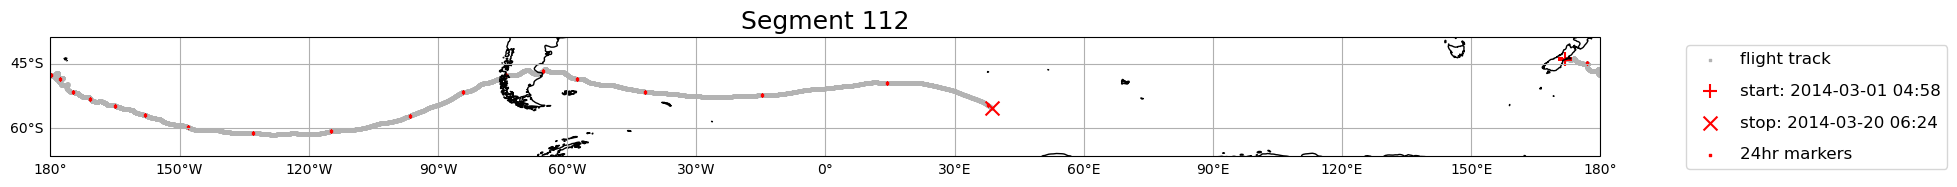

In [5]:
# Select one segment
segment = flights[flights.segment_id == 112] # segment 112 (flight I-160) is the segment in the paper
#segment = flights[flights.segment_id == 10227] # an interesting tropical segment

# Plot the segment
plt.figure(figsize=(20,20))
lat = np.array(segment.latitude.copy())
lon = np.array(segment.longitude.copy())
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
ax.set_extent([np.max([-180, np.min(lon)-5]), 
               np.min([180, np.max(lon)+5]), 
               np.max([-90, np.min(lat)-5]),
               np.min([90, np.max(lat)+5])], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # Options are 110m, 50m, 10m
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180.,181.,30))
gl.ylocator = mticker.FixedLocator(np.arange(-90.,91.,15))
plots = np.ndarray(shape=4,dtype='object')
plots[0] = plt.scatter(lon, lat, s=1, marker='s', color=[0.7,0.7,0.7], transform=ccrs.PlateCarree())
plots[1] = plt.scatter(lon[0], lat[0], s=100, marker='+', color='r', transform=ccrs.PlateCarree())
plots[2] = plt.scatter(lon[-1], lat[-1], s=100, marker='x', color='r', transform=ccrs.PlateCarree())
plots[3] = plt.scatter(lon[0:-1:4*180], lat[0:-1:4*180], s=1, marker='s', color='r', transform=ccrs.PlateCarree())
plt.title('Segment '+str(segment.segment_id.iloc[0]), fontsize=18)
labels = np.ndarray(shape=4,dtype='object')
labels[0] = 'flight track'
labels[1] = 'start: '+str(segment.time.iloc[0].floor('min'))[:-3]
labels[2] = 'stop: '+str(segment.time.iloc[-1].floor('min'))[:-3]
labels[3] = '24hr markers'
leg = plt.legend(plots, labels, fontsize=12, bbox_to_anchor=(1.05, 1),
                     loc='upper left', labelspacing=1);
#fig.savefig('temp1.png', format='png', bbox_inches='tight');

### Wavelet analysis function

Following the equations and nomenclature of Torrence and Compo 1998.

In [6]:
## WAVELET ANALYSIS
# Create a dataclass for the variables returned from the wavelet analysis
@dataclass
class ReturnValue:
    wave: float;         scales: float;         freqs: float;             coi: float;  
    period: float;       wave_amp: float;       Cdelta: float;            glbl_power: float;
    wave_totalpower: float; iwave: float;       wave_power: float;

# The input time series must be detrended and normalized by the standard deviation std
# Make sure there aren't any NaNs in any of the input variables
def run_wavelet(X_norm,std,t,dt,dj,s0,J,omega0):
    
    N = np.size(t)
    var = std**2
    # Pad X_norm with zeros, giving it a length of 4*N_temp
    N_temp = int(np.ceil(N/2))
    X_pad = np.zeros(4*N_temp)
    X_pad[N_temp:N_temp + N] = X_norm
    factor = 4*N_temp/N
        
    # Calculate frequencies, periods, scales for the wavelet analysis on the padded timeseries
    fftfreqs = np.fft.fftfreq(4*N_temp,dt)
    omega = 2*np.pi*fftfreqs
    s = s0*2**(dj*np.arange(int(J))) # TC98 eq. 9
    scales = s
    period = 4*np.pi*s/(omega0 + np.sqrt(2 + omega0**2)) # TC98 table 1; wavelet equivalent FFT period
    freqs = 1/period
    # Tile for calculating the wavelet transform
    omega = np.tile(omega,(int(J),1))
    s = np.tile(s,(4*N_temp,1)).swapaxes(0,1)
        
    # Calculate psi_hat
    psi_0_0 = np.pi**-0.25 # TC98 table 2
    psi_0 = (np.pi**-0.25)*np.heaviside(omega,0)*np.exp(-0.5*(s*omega - omega0)**2) # TC98 table 1
    psi_hat = np.sqrt(2*np.pi*s/dt)*psi_0 # TC98 eq. 6
        
    # Do the fft and ifft of the padded timeseries to get the wavelet transform
    temp = np.tile(np.fft.fft(X_pad),(int(J),1))
    wave = np.fft.ifft(temp*np.conj(psi_hat),axis=1) # TC98 eq. 4
        
    # Dimensional amplitude spectra
    wave_amp = (2*std/np.sqrt(N))*wave
        
    # Wavelet power (used for significance testing) and Cdelta
    wave_power = 2*var*np.abs(wave)**2
    wave_totalpower = (factor*var*dj*dt/(4*N_temp))*np.sum(np.abs(wave**2)/s) # TC98 eq. 14
    Cdelta = wave_totalpower/var # The Cdelta necessary to match the wavelet total power to the input variance
    wave_totalpower = wave_totalpower/Cdelta
        
    # Reconstruct the original time series and chop off the zero padding
    iwave = (dj*np.sqrt(dt)/(Cdelta*psi_0_0))*np.sum(np.real(wave)/np.sqrt(s),axis=0) # TC98 eq. 11
    iwave = std*iwave[N_temp:N_temp+N]
    wave = wave[:,N_temp:N_temp+N]
    wave_amp = wave_amp[:,N_temp:N_temp+N]
    wave_power = wave_power[:,N_temp:N_temp+N]
        
    # Calculate the COI (outputs the scale)
    coi = t*(2**-0.5) # TC98 table 1
    coi = np.minimum(coi, np.flipud(coi))
    
    # Add in the global power calculation, so the spectrum can be plotted
    glbl_power = wave_power.mean(axis=1)
        
    return ReturnValue(wave,scales,freqs,coi,period,wave_amp,Cdelta,glbl_power,wave_totalpower,iwave,wave_power)

### Prepare the segment for analysis

rho_bar: 0.08311831764620863
H: 6380.9760480562845
Nref: 0.021385873605811588
Z_EDS: 0.29397681869016135


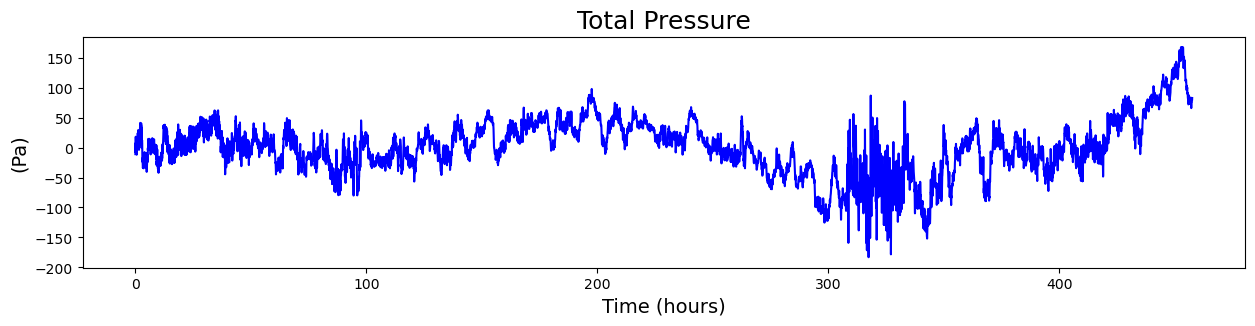

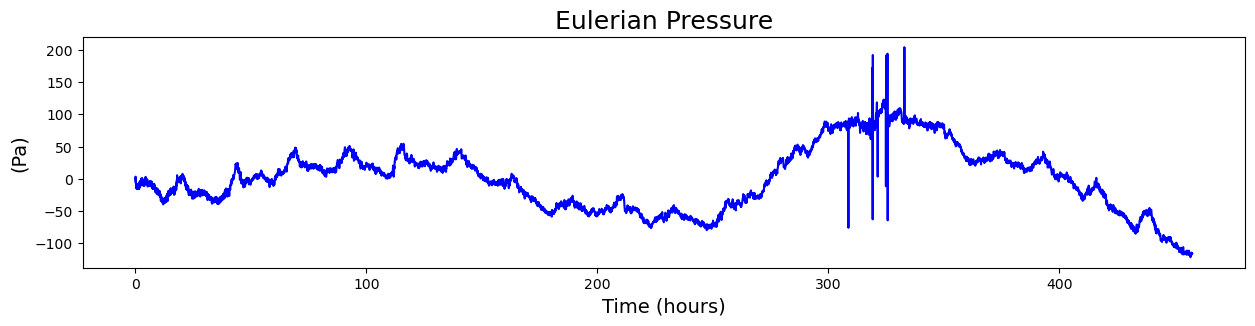

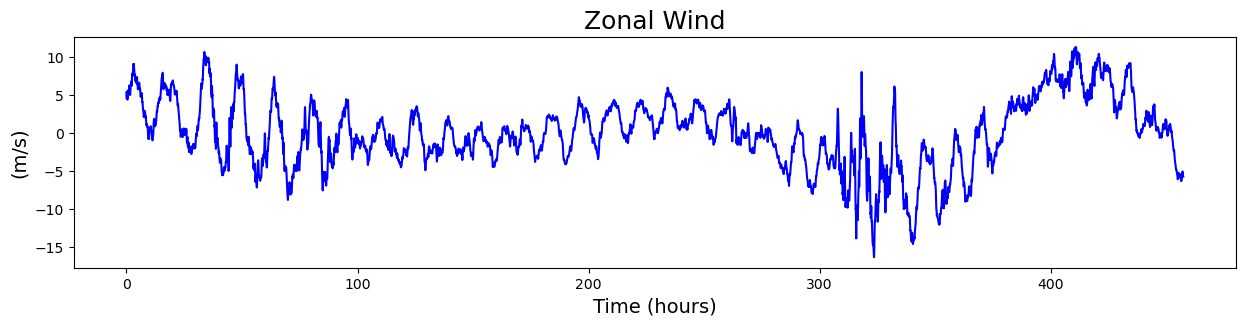

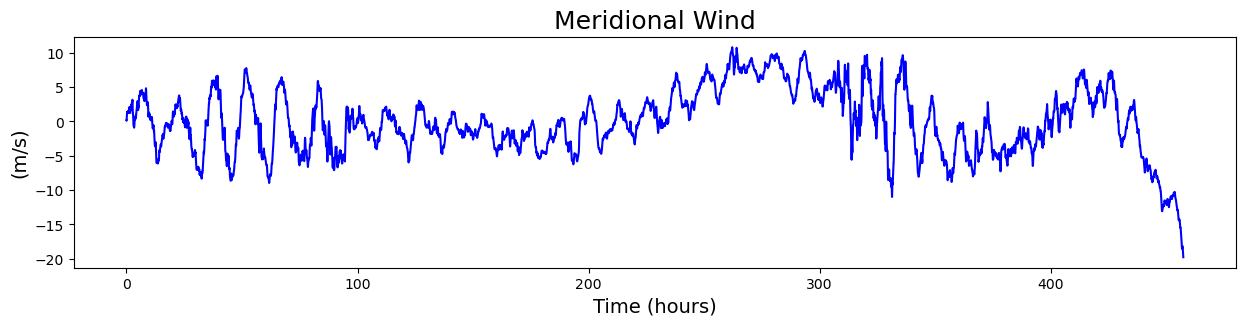

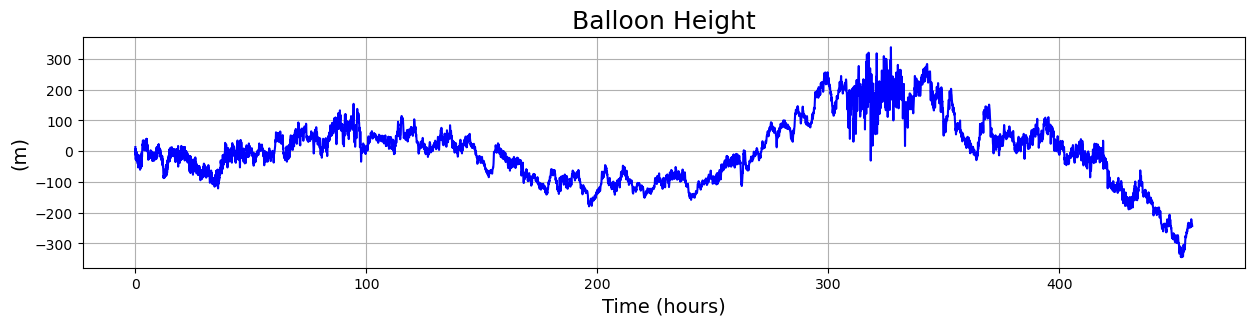

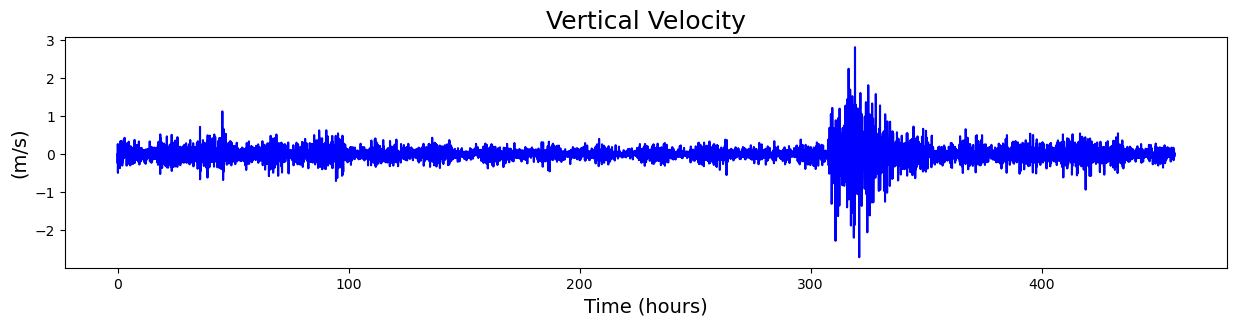

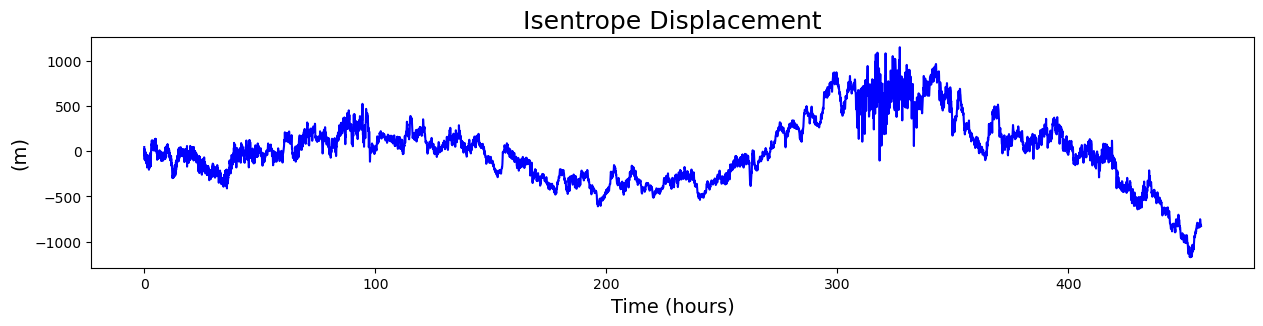

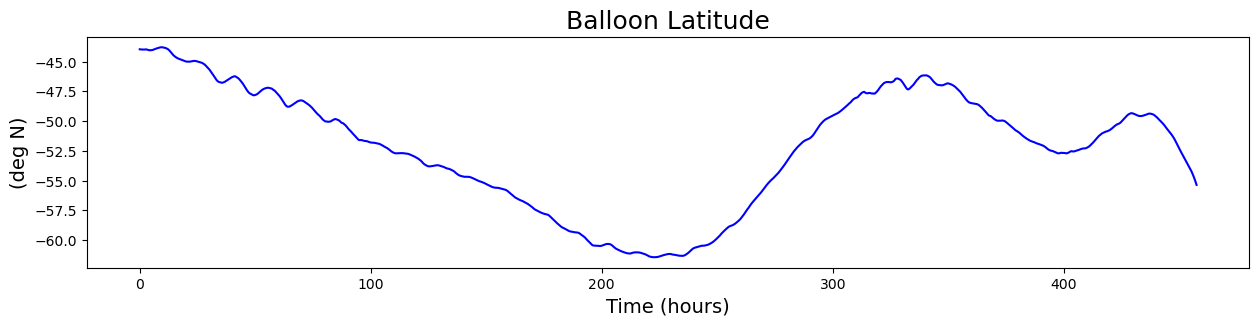

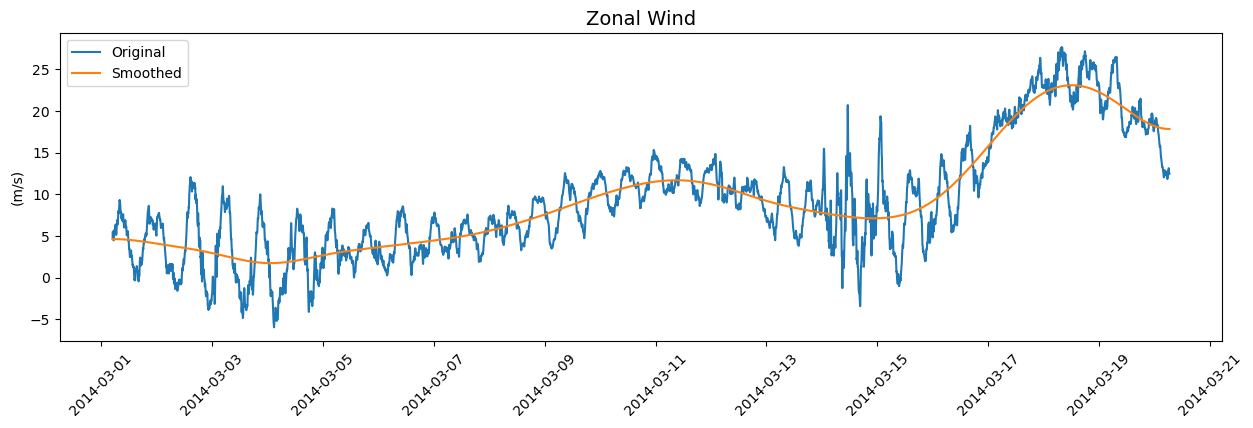

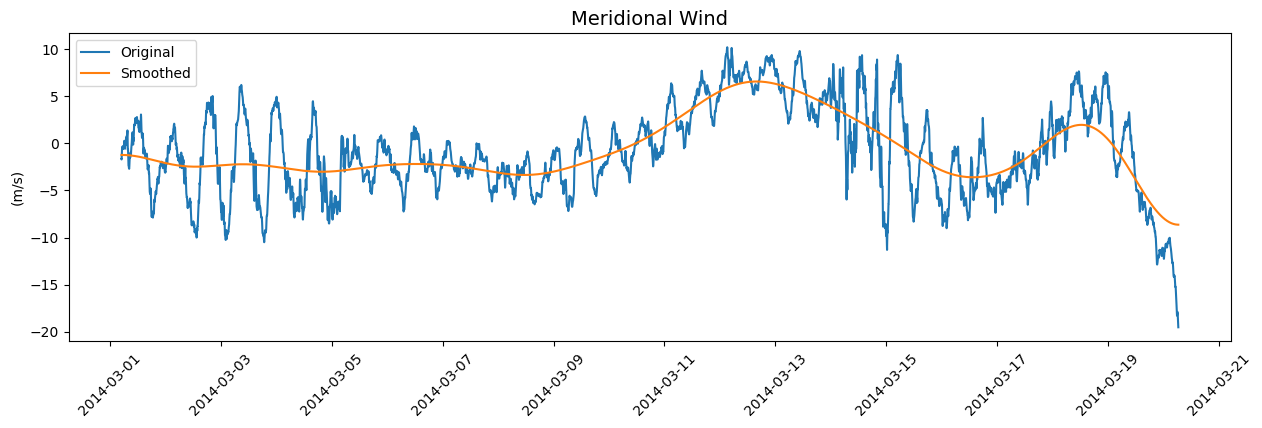

In [7]:
# Convert time to a numpy array with units of minutes
t = np.array((segment.time - segment.time.iloc[0])/pd.Timedelta('1 minutes'))
N = np.size(t)
# Make other variables arrays
u = np.array(segment.wind_u)
v = np.array(segment.wind_v)
pt = 100*np.array(segment.pressure) # the Zenodo data has pressure units of hPa; convert to Pa
altitude = np.array(segment.altitude)
balloon_lat = np.array(segment.latitude)
T_env = np.array(segment.T_cosmic) + 273.15 # COSMIC temperatures are in degrees Celsius; convert to Kelvin
dTdz_env = np.array(segment.dTdz_cosmic)

# When N_cosmic = 0, set T_env and dTdz_env to np.nan
# Later, when flight-mean rho_bar, H, Nref, and Z_EDS are calculated, use np.nanmean
N_cosmic = np.array(segment.N_cosmic)
T_env[N_cosmic == 0] = np.nan
dTdz_env[N_cosmic == 0] = np.nan
    
# Calculate segment mean density. Because Loon temperature data is unreliable, use the
# environmental temperature from the COSMIC profiles
rho_bar = np.nanmean(pt/(R*T_env))

# Calculate the segment mean density scale height (CHECK THAT RT/g IS THE APPROPRIATE FORMULATION)
H = np.nanmean(R*T_env/g)

# Calculate the segment mean Coriolis parameter
f = np.mean(2*Omega*np.sin(np.pi*balloon_lat/180))
    
# Calculate the time series of the environmental buoyancy frequency and Z_EDS
Nref = np.sqrt((g/T_env)*((g/cp) + dTdz_env)) # VH14 Eq. 6
Z_EDS = ((g/cp) + dTdz_env)/((g/R) + dTdz_env) # Vincent and Alexander 2020, Eq. 7
# As a start, to keep things simple, average them in time
Nref = np.nanmean(Nref)
Z_EDS = np.nanmean(Z_EDS)
print('rho_bar:', rho_bar)
print('H:', H)
print('Nref:', Nref)
print('Z_EDS:', Z_EDS)
    
# The magnitude of the w uncertainty is the balloon altitude uncertainty times sqrt(2)/(dt*Z_EDS).
w_uncertainty = np.sqrt(2)*delta_b_uncertainty/(60*dt*Z_EDS)

# Calculate "smooth" velocities by using a Gaussian filter. The width (standard deviation) of the filter
# is determined by the longest period GW: either the Coriolis period or GW_PERIOD_MAX.
width = 2*Omega*np.sin(np.pi*np.max(np.abs(balloon_lat))/180) # Coriolis frequency, in 1/seconds
width = width/(2*np.pi) # convert from angular frequency to cyclic frequency
width = 1/(60*width) # period, in minutes
width = min(width, GW_PERIOD_MAX)/dt
u_smooth = gaussian_filter(u, sigma=width)
v_smooth = gaussian_filter(v, sigma=width)
    
# Create time series of anomalies by detrending
u = scipy.signal.detrend(u)
v = scipy.signal.detrend(v)
pt = scipy.signal.detrend(pt)
delta_b = scipy.signal.detrend(altitude)

# Back out the Eulerian pressure perturbation
p = pt + rho_bar*g*delta_b # VH14 Eq. 21
    
# Calculate delta_theta and w, using Z_EDS
delta_theta = delta_b/Z_EDS
w = np.zeros(shape=(N)) # choose not to worry about the first and last value of w
w[1:-1] = 0.5*(delta_theta[2:] - delta_theta[:-2])/(60*dt) # make sure dt is in seconds, not minutes
    
# Set parameters for the wavelet calculation that depend on N:
# Calculate J so that the maximum resolved period is at least as big as N*dt/2
s_max = (N*dt/2)*(omega0 + np.sqrt(2 + omega0**2))/(4*np.pi) # An inversion of TC98 table 1
J = (1/dj)*np.log2(s_max/s0) # an inversion of TC98 eq. 9
J = (1/dj)*np.ceil(J*dj)

# Calculate the mean EKE and potential energy
EKE = 0.5*np.mean(u**2 + v**2 + w**2)
EPE = 0.5*(Nref**2)*np.mean(delta_theta**2) # Eq. 2, Podglajen et al 2016

## PLOTS
plt.figure(figsize=(15,3))
plt.plot(t/60,pt,'b')
plt.title('Total Pressure', fontsize=18)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('(Pa)', fontsize=14);

plt.figure(figsize=(15,3))
plt.plot(t/60,p,'b')
plt.title('Eulerian Pressure', fontsize=18)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('(Pa)', fontsize=14);

plt.figure(figsize=(15,3))
plt.plot(t/60,u,'b')
plt.title('Zonal Wind', fontsize=18)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('(m/s)', fontsize=14);

plt.figure(figsize=(15,3))
plt.plot(t/60,v,'b')
plt.title('Meridional Wind', fontsize=18)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('(m/s)', fontsize=14);

plt.figure(figsize=(15,3))
plt.plot(t/60,delta_b,'b')
plt.grid()
plt.title('Balloon Height', fontsize=18)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('(m)', fontsize=14);

plt.figure(figsize=(15,3))
plt.plot(t/60,w,'b')
plt.title('Vertical Velocity', fontsize=18)
#plt.ylim(-10, 10)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('(m/s)', fontsize=14);

plt.figure(figsize=(15,3))
plt.plot(t/60,delta_theta,'b')
plt.title('Isentrope Displacement', fontsize=18)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('(m)', fontsize=14);

plt.figure(figsize=(15,3))
plt.plot(t/60,balloon_lat,'b')
plt.title('Balloon Latitude', fontsize=18)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('(deg N)', fontsize=14);

plt.figure(figsize = (15,4))
plt.plot(segment.time, segment.wind_u)
plt.plot(segment.time, u_smooth)
plt.xticks(rotation = 45)
plt.title('Zonal Wind',fontsize=14)
plt.ylabel('(m/s)')
plt.legend(['Original','Smoothed']);

plt.figure(figsize = (15,4))
plt.plot(segment.time, segment.wind_v)
plt.plot(segment.time, v_smooth)
plt.xticks(rotation = 45)
plt.title('Meridional Wind',fontsize=14)
plt.ylabel('(m/s)')
plt.legend(['Original','Smoothed']);

### Run the wavelet analysis

In [8]:
# Get the number of time steps
N = np.size(t)

# Normalize the time series
std_w = np.std(w)
std_u = np.std(u)
std_v = np.std(v)
std_delta_theta = np.std(delta_theta)
std_delta_b = np.std(delta_b)
std_p = np.std(p)
std_pt = np.std(pt)
w_norm = w/std_w
u_norm = u/std_u
v_norm = v/std_v
delta_theta_norm = delta_theta/std_delta_theta
delta_b_norm = delta_b/std_delta_b
p_norm = p/std_p
pt_norm = pt/std_pt
var_w = std_w**2
var_u = std_u**2
var_v = std_v**2
var_delta_theta = std_delta_theta**2
var_delta_b = std_delta_b**2
var_p = std_p**2
var_pt = std_pt**2

# Run the wavelet analysis
# The wavelet analysis won't work if there are any NaNs
w_output = run_wavelet(w_norm,std_w,t,dt,dj,s0,J,omega0)
u_output = run_wavelet(u_norm,std_u,t,dt,dj,s0,J,omega0)
v_output = run_wavelet(v_norm,std_v,t,dt,dj,s0,J,omega0)
delta_theta_output = run_wavelet(delta_theta_norm,std_delta_theta,t,dt,dj,s0,J,omega0)
delta_b_output = run_wavelet(delta_b_norm,std_delta_b,t,dt,dj,s0,J,omega0)
p_output = run_wavelet(p_norm,std_p,t,dt,dj,s0,J,omega0)
pt_output = run_wavelet(pt_norm,std_pt,t,dt,dj,s0,J,omega0)

# Pull out a couple common variables to make some calculations easier
period = u_output.period; freqs = u_output.freqs; scales = u_output.scales
# Average Cdelta from u and v output to try to reduce the influence of noise
Cdelta = 0.5*(u_output.Cdelta + v_output.Cdelta)



## TEST WAVELET COEFFICIENTS FOR SIGNIFICANCE AGAINST INSTRUMENTAL UNCERTAINTY
# If the amplitude coefficients must be a factor SN_RATIO_THRESH above the noise
# floor, then the wavelet power must be SN_RATIO_THRESH**2 above the noise floor
# Make uncertainty power spectra for u, v, w, fitting a one-sided power spectrum 
# of the shape omega**2 to the uncertainty magnitude:
fftfreqs_np = np.fft.fftfreq(N,dt)
fftfreqs_np = fftfreqs_np[:np.int(np.ceil(N/2))] # make the fft spectrum one-sided
fft_power = (1/N)*np.sum(fftfreqs_np**2)
u_uncertainty_power = (fftfreqs_np*u_uncertainty)**2/fft_power
v_uncertainty_power = (fftfreqs_np*v_uncertainty)**2/fft_power
w_uncertainty_power = (fftfreqs_np*w_uncertainty)**2/fft_power
# Interpolate these spectra to the wavelet frequencies
interp_function = interpolate.PchipInterpolator(fftfreqs_np, u_uncertainty_power)
u_uncertainty_power = interp_function(freqs)
interp_function = interpolate.PchipInterpolator(fftfreqs_np, v_uncertainty_power)
v_uncertainty_power = interp_function(freqs)
interp_function = interpolate.PchipInterpolator(fftfreqs_np, w_uncertainty_power)
w_uncertainty_power = interp_function(freqs)
# Test the wavelet power against the power of the uncertainty
u_significant = u_output.wave.copy()
v_significant = v_output.wave.copy()
w_significant = w_output.wave.copy()
temp = np.tile(u_uncertainty_power, (N,1)).swapaxes(0,1)
temp = u_output.wave_power/temp
significant_u = np.ones(shape=temp.shape) # for plotting: 1 = significant, 0 = not
u_significant[temp < SN_RATIO_THRESH**2] = 0
significant_u[temp < SN_RATIO_THRESH**2] = 0
temp = np.tile(v_uncertainty_power, (N,1)).swapaxes(0,1)
temp = v_output.wave_power/temp
v_significant[temp < SN_RATIO_THRESH**2] = 0
temp = np.tile(w_uncertainty_power, (N,1)).swapaxes(0,1)
temp = w_output.wave_power/temp
significant_w = np.ones(shape=temp.shape) # for plotting: 1 = significant, 0 = not
w_significant[temp < SN_RATIO_THRESH**2] = 0
significant_w[temp < SN_RATIO_THRESH**2] = 0
significant_uw = significant_u*significant_w # this will be = 1 when the cross-spectrum is significant
                                             # and = 0 when it is not






## OUTPUT
# Check that the total variance is conserved
print('Variances:   time series           wavelet')
print(f'Eul. pres.:  {var_p},   {p_output.wave_totalpower.mean()}')
print(f'Total pres.:  {var_pt},   {pt_output.wave_totalpower.mean()}')
print(f'Vert. vel.:  {var_w},   {w_output.wave_totalpower.mean()}')
print(f'Zonal wind:  {var_u},   {u_output.wave_totalpower.mean()}')
print(f'Merid. wind: {var_v},   {v_output.wave_totalpower.mean()}')

Variances:   time series           wavelet
Eul. pres.:  2415.0201811276447,   2415.0201811276447
Total pres.:  2089.7289970435963,   2089.7289970435963
Vert. vel.:  0.038018404922105876,   0.038018404922105876
Zonal wind:  20.087511069079582,   20.087511069079582
Merid. wind: 22.197127263583926,   22.197127263583926


### Calculate the cross-spectrum and the momentum flux time series

In [9]:
# Calculate the cross-spectra of u, v and the vertical velocity
crossspec_u_w = w_output.wave*np.conj(u_output.wave) # this is the normalized spectrum
crossspec_v_w = w_output.wave*np.conj(v_output.wave) # this is the normalized spectrum

## ELIMINATE THE WAVELET COEFFICIENTS WITH PERIODS TOO HIGH OR TOO LOW
nscales = scales.shape[0]
crossspec_u_w_full = crossspec_u_w.copy()
crossspec_v_w_full = crossspec_v_w.copy()
period_tiled = np.tile(period,(N,1)).swapaxes(0,1)
# Eliminate coefficients with periods shorter than either the buoyancy period or GW_PERIOD_MIN
period_N = 2*np.pi*np.ones(N)/(60*Nref) # the buoyancy period
min_period = np.maximum(GW_PERIOD_MIN,period_N)
temp = np.tile(min_period, (nscales,1)) - period_tiled
crossspec_u_w[temp >= 0] = 0
crossspec_v_w[temp >= 0] = 0
# Eliminate coefficients at periods too close to (IO_PERIOD_THRESH) either the Coriolis period or GW_PERIOD_MAX
period_f = 2*Omega*np.sin(np.pi*balloon_lat/180)
period_f = np.abs(2*np.pi/(60*period_f))
max_period = np.minimum(GW_PERIOD_MAX,IO_PERIOD_THRESH*period_f)
temp = np.tile(max_period, (nscales,1)) - period_tiled
crossspec_u_w[temp < 0] = 0
crossspec_v_w[temp < 0] = 0

# Calculate the cross-spectra of u, v and the vertical velocity
crossspec_u_w_sig = w_significant*np.conj(u_significant) # this is the normalized spectrum
crossspec_v_w_sig = w_significant*np.conj(v_significant) # this is the normalized spectrum
crossspec_u_w_sig_full = crossspec_u_w_sig.copy()
crossspec_v_w_sig_full = crossspec_v_w_sig.copy()
### CONVERT THE MOMENTUM FLUX TO THE PSEUDOMOMENTUM FLUX
#f_temp = 2*Omega*np.abs(np.sin(np.pi*balloon_lat/180))
#f_temp = np.tile(f_temp,(nscales,1))
#freq_temp = np.tile(2*np.pi*freqs/60,(N,1)).swapaxes(0,1)
#pseudomomentum_factor = 1 - (f_temp/freq_temp)**2
#crossspec_u_w_sig = crossspec_u_w_sig*pseudomomentum_factor
#crossspec_v_w_sig = crossspec_v_w_sig*pseudomomentum_factor
#crossspec_u_w_sig_full = crossspec_u_w_sig.copy()
#crossspec_v_w_sig_full = crossspec_v_w_sig.copy()
## ELIMINATE THE WAVELET COEFFICIENTS WITH PERIODS TOO HIGH OR TOO LOW
period_tiled = np.tile(period,(N,1)).swapaxes(0,1)
# Eliminate coefficients with periods shorter than either the buoyancy period or GW_PERIOD_MIN
period_N = 2*np.pi*np.ones(N)/(60*Nref) # the buoyancy period
min_period = np.maximum(GW_PERIOD_MIN,period_N)
temp = np.tile(min_period, (nscales,1)) - period_tiled
crossspec_u_w_sig[temp >= 0] = 0
crossspec_v_w_sig[temp >= 0] = 0
# Eliminate coefficients at periods too close to (IO_PERIOD_THRESH) either the Coriolis period or GW_PERIOD_MAX
period_f = 2*Omega*np.sin(np.pi*balloon_lat/180)
period_f = np.abs(2*np.pi/(60*period_f))
max_period = np.minimum(GW_PERIOD_MAX,IO_PERIOD_THRESH*period_f)
temp = np.tile(max_period, (nscales,1)) - period_tiled
crossspec_u_w_sig[temp < 0] = 0
crossspec_v_w_sig[temp < 0] = 0
# Integrate across scale to make a time series of the cross spectrum
cross_totalpower_u_w_sig = (scales*np.ones((N,1))).transpose()
cross_totalpower_u_w_sig = np.real(crossspec_u_w_sig)/cross_totalpower_u_w_sig
cross_totalpower_u_w_sig = (std_u*std_w*dj*dt/Cdelta)*np.sum(cross_totalpower_u_w_sig,axis=0)
cross_totalpower_v_w_sig = (scales*np.ones((N,1))).transpose()
cross_totalpower_v_w_sig = np.real(crossspec_v_w_sig)/cross_totalpower_v_w_sig
cross_totalpower_v_w_sig = (std_v*std_w*dj*dt/Cdelta)*np.sum(cross_totalpower_v_w_sig,axis=0)
# Calculate the East/West and North/South components of the momentum flux seperately, by
# setting values of the opposite sign to zero
scales_tiled = np.tile(scales, (N,1)).swapaxes(0,1)
temp = np.real(crossspec_u_w_sig).copy()
temp[temp < 0] = 0
cross_totalpower_eastward_sig = (std_u*std_w*dj*dt/Cdelta)*np.sum(temp/scales_tiled,axis=0)
temp = np.real(crossspec_u_w_sig).copy()
temp[temp > 0] = 0
cross_totalpower_westward_sig = (std_u*std_w*dj*dt/Cdelta)*np.sum(temp/scales_tiled,axis=0)
temp = np.real(crossspec_v_w_sig).copy()
temp[temp < 0] = 0
cross_totalpower_northward_sig = (std_v*std_w*dj*dt/Cdelta)*np.sum(temp/scales_tiled,axis=0)
temp = np.real(crossspec_v_w_sig).copy()
temp[temp > 0] = 0
cross_totalpower_southward_sig = (std_v*std_w*dj*dt/Cdelta)*np.sum(temp/scales_tiled,axis=0)

# Define the low- and high-frequency wave cutoffs (as periods)
# Set the minimum and maximum periods:
period_tiled = np.tile(period,(N,1)).swapaxes(0,1)
period_N = 2*np.pi*np.ones(N)/(60*Nref) # the buoyancy period
period_f = 2*Omega*np.sin(np.pi*balloon_lat/180)
period_f = np.abs(2*np.pi/(60*period_f)) # the Coriolis period
shortest_period = np.maximum(GW_PERIOD_MIN,period_N)
longest_period = np.minimum(GW_PERIOD_MAX,period_f)
# Evenly spaced log10 of frequency:
highest_freq = 2*np.pi/shortest_period
lowest_freq = 2*np.pi/longest_period
temp1 = np.log10(highest_freq)
temp2 = np.log10(lowest_freq)
short_cutoff = temp1 - (temp1 - temp2)/3
short_cutoff = 2*np.pi/(10**short_cutoff)
long_cutoff = temp1 - 2*(temp1 - temp2)/3
long_cutoff = 2*np.pi/(10**long_cutoff)

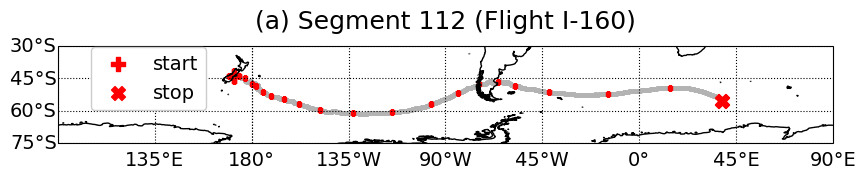

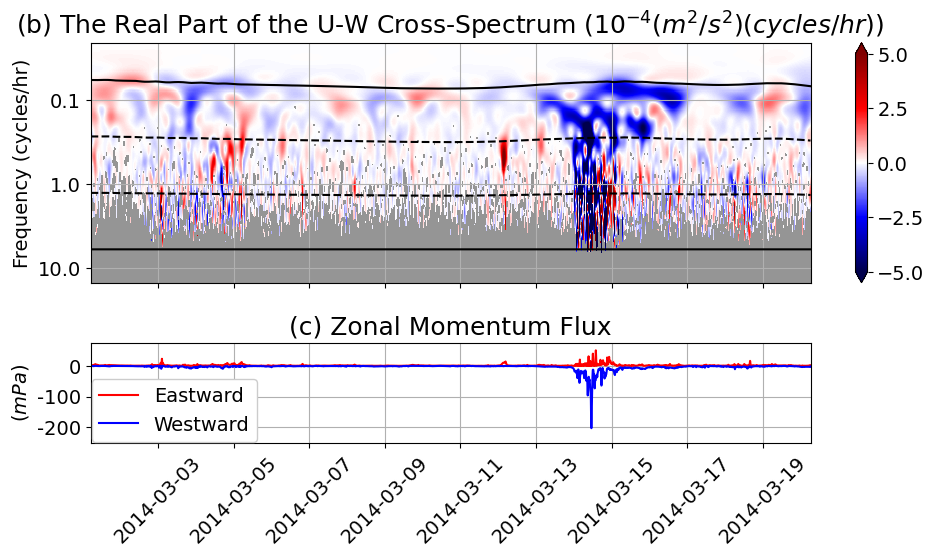

In [10]:
# Plot the segment
plt.figure(figsize=(10,5))
lat = np.array(segment.latitude.copy())
lon = np.array(segment.longitude.copy())
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-90.0, globe=None))
ax.set_extent([-180, 180, -75.1, -29.9], crs=ccrs.PlateCarree())
#ax.set_extent([-180, -45, 0, 20.1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # Options are 110m, 50m, 10m
gl = ax.gridlines(draw_labels=True, color='k', linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180.,181.,45))
gl.ylocator = mticker.FixedLocator(np.arange(-90.,91.,15))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
plots = np.ndarray(shape=6,dtype='object')
plots[0] = plt.scatter(lon[0], lat[0], s=100, marker='P', color='r', transform=ccrs.PlateCarree())
plots[1] = plt.scatter(lon[-1], lat[-1], s=100, marker='X', color='r', transform=ccrs.PlateCarree())
plots[2] = plt.scatter(lon, lat, s=1, marker='s', color=[0.7,0.7,0.7], transform=ccrs.PlateCarree())
plots[3] = plt.scatter(lon[0], lat[0], s=100, marker='P', color='r', transform=ccrs.PlateCarree())
plots[4] = plt.scatter(lon[-1], lat[-1], s=100, marker='X', color='r', transform=ccrs.PlateCarree())
plots[5] = plt.scatter(lon[0:-1:4*180], lat[0:-1:4*180], s=5, marker='s', color='r', transform=ccrs.PlateCarree())
plt.title(f'(a) Segment {segment.segment_id.iloc[0]} (Flight {segment.flight_id.iloc[0]})', fontsize=18)
labels = np.ndarray(shape=2,dtype='object')
labels[0] = 'start'
labels[1] = 'stop'
leg = plt.legend(plots, labels, 
                 bbox_to_anchor=(0.03, 1.09), loc='upper left',
                 fancybox=True, framealpha=1, fontsize=14);
#plt.savefig('temp1.png', format='png', bbox_inches='tight');
#plt.savefig('temp1.pdf', format='pdf', bbox_inches='tight');

# Plot the wavelet cross-spectrum
fig = plt.figure(figsize=(9,4))
ax3 = plt.axes([0, 0.4, 1, 0.6])
temp = (4*std_u*std_w/N)*np.real(crossspec_u_w_full) # Make the amplitude dimensional
freqs_temp = np.tile(60*freqs,(N,1)).swapaxes(0,1)
fig3 = ax3.pcolormesh(segment.time,np.log10(60*freqs),1E4*freqs_temp*temp,
                    cmap='seismic',vmin=-5.01,vmax=5.01)
cbar = fig.colorbar(fig3,extend = 'both')
temp = significant_uw.copy()
cbar.ax.tick_params(labelsize=14)
ax3.contourf(segment.time,np.log10(60*freqs),temp,[-99,0],cmap='Greys')
period_N = 2*np.pi*np.ones(N)/(60*Nref) # the buoyancy period
min_period = np.maximum(GW_PERIOD_MIN,period_N)
ax3.plot(segment.time,np.log10(60/min_period),'k')
ax3.plot(segment.time,np.log10(60/period_f),'k')
ax3.plot(segment.time,np.log10(60/short_cutoff),'--k')
ax3.plot(segment.time,np.log10(60/long_cutoff),'--k')
ax3.grid()
ax3.set_title('(b) The Real Part of the U-W Cross-Spectrum $(10^{-4}(m^{2}/s^{2})(cycles/hr))$', fontsize=18)
ax3.set_ylabel('Frequency (cycles/hr)',fontsize=14)
Yticks = 10**np.arange(np.ceil(np.log10(60*freqs.min())),np.ceil(np.log10(60*freqs.max())))
ax3.set_yticks(np.log10(Yticks))
ax3.set_yticklabels(Yticks,fontsize=14)
ax3.set_xticklabels([])
ax3.set_xlim(segment.time.iloc[0],segment.time.iloc[-1])
ax3.set_ylim(np.log10(60/4),np.log10(1/(2*24)))

ax1 = plt.axes([0, 0, 0.8, 0.25])
ax1.plot(segment.time, 1000*rho_bar*cross_totalpower_eastward_sig, 'r')
ax1.plot(segment.time, 1000*rho_bar*cross_totalpower_westward_sig, 'b')
ax1.grid()
ax1.set_xlim(segment.time.iloc[0],segment.time.iloc[-1])
ax1.set_ylim(-250,75)
#ax1.set_ylim(-100,50)
ax1.set_yticks([-200,-100,0],['-200','-100','0'],fontsize=14)
ax1.tick_params('x',rotation=45, labelsize=14)
ax1.set_title('(c) Zonal Momentum Flux', fontsize=18)
ax1.set_ylabel('$(mPa)$',fontsize=14)
ax1.legend(['Eastward','Westward'], 
           bbox_to_anchor=(-0.012,-0.09), loc='lower left', fancybox=True, framealpha=1,fontsize=14);
#fig.savefig('temp2.png', format='png', bbox_inches='tight');
#fig.savefig('temp2.pdf', format='pdf', bbox_inches='tight');

(13724,) (13724,) ['2014-03-01T04:58:52.009000000' '2014-03-01T05:00:52.009000000'
 '2014-03-01T05:02:52.009000000' ... '2014-03-20T06:20:52.009000000'
 '2014-03-20T06:22:52.009000000' '2014-03-20T06:24:52.009000000']
Mean total flux (mPa): 58.795337594977546
Total distance covered (km): 355.1448485969666
Segment mean altitude (km): 20.47250982472842


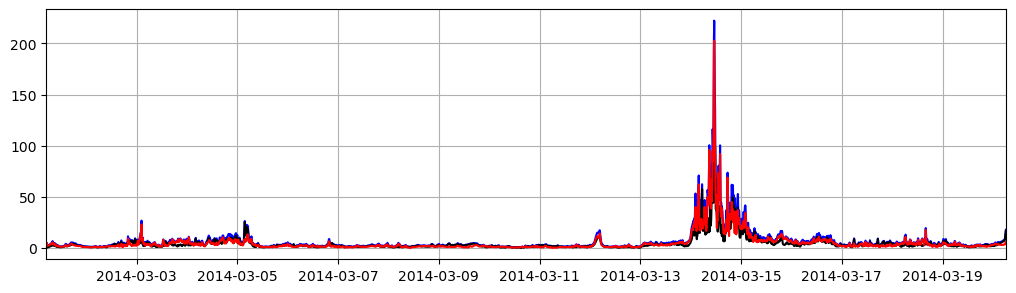

In [44]:
# The mean momentum flux when the balloon passes over the Andes
r_earth = 6.378E6 # radius of the Earth in meters

temp_time = np.array(segment.time)
print(temp_time.shape, cross_totalpower_eastward_sig.shape, temp_time)
temp_totalflux = 1000*rho_bar*np.sqrt((cross_totalpower_eastward_sig-cross_totalpower_westward_sig)**2 + 
                                      (cross_totalpower_northward_sig-cross_totalpower_southward_sig)**2)
fig = plt.figure(figsize=(12,10))
ax1 = plt.axes([0, 0.85, 0.8, 0.25])
ax1.plot(temp_time, temp_totalflux, 'b')
ax1.plot(temp_time, 1000*rho_bar*(cross_totalpower_northward_sig-cross_totalpower_southward_sig), 'k')
ax1.plot(temp_time, 1000*rho_bar*(cross_totalpower_eastward_sig-cross_totalpower_westward_sig), 'r')
ax1.grid()
ax1.set_xlim(temp_time[0],temp_time[-1]);

# Total momentum flux
temp = temp_totalflux[temp_time >= np.datetime64('2014-03-14T06:00:00.000000000')]
temp_temp_time = temp_time[temp_time >= np.datetime64('2014-03-14T06:00:00.000000000')]
temp = temp[temp_temp_time < np.datetime64('2014-03-14T18:00:00.000000000')]
print('Mean total flux (mPa):', np.nanmean(temp))

# Change in latitude and longitude
temp = segment.copy()
temp = temp[temp.time >= pd.Timestamp('2014-03-14 06:00:00')]
temp = temp[temp.time < pd.Timestamp('2014-03-14 18:00:00')]
lat = np.array(temp.latitude.copy())
lon = np.array(temp.longitude.copy())
lat_mean = 0.5*(lat[1:] + lat[:-1])
dlat = np.abs(lat[1:] - lat[:-1])
dlon = np.abs(lon[1:] - lon[:-1])
dx = r_earth*np.cos(np.pi*lat_mean/180)*(np.pi*dlon/180)
dy = r_earth*(np.pi*dlat/180)
dh = np.sqrt(dx**2 + dy**2)
print('Total distance covered (km):', np.nansum(dh)/1000)
print('Segment mean altitude (km):', segment.altitude.mean()/1000)